In [2]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from scipy.stats import chi2_contingency
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


In [3]:
def jupyter_settings():
    # Inline plotting
    %matplotlib inline
    # %pylab inline

    # Matplotlib settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    # Display settings
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None #Allows displaying all columns of a DataFrame.
    pd.options.display.max_rows = None # Allows displaying all rows of a DataFrame
    pd.set_option( 'display.expand_frame_repr', False ) #Prevents the DataFrame from being truncated when printed.

    # Seaborn settings
    sns.set() #Applies the default Seaborn style to plots.

jupyter_settings()


# 2.0 Data Loading and Preparation

## 1.2 Loading Data

In [4]:
# Load the datasets
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False ) # The low_memory=False parameter is used to ensure that the entire file is read at once, which can help avoid issues with mixed data types.
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False ) # The low_memory=False parameter is used to ensure that the entire file is read at once, which can help avoid issues with mixed data types.

# Merge the datasets on the 'Store' column
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' ) #left join. This means all rows from df_sales_raw will be included, and the matching rows from df_store_raw will be added. If there is no match, the result will have NaN values for columns from df_store_raw.

# Data Copy and Column Renaming

In [5]:
df1 = df_raw.copy()
# df1.head()

## 2.1 Rename Columns

In [6]:
# List of original column names
cols_old = ['Store', 'DayOfyear', 'Date', 'Sales', 'Customers', 'Open',
            'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


# Lambda function to convert camel case to snake case
snakecase = lambda x: inflection.underscore( x )

# Apply the function to each column name in cols_old
cols_new = list( map( snakecase, cols_old ) )

# Rename the columns of the DataFrame
df1.columns = cols_new

# df1.head()

# 3.0 Data Exploration

## 3.1 Data Dimensions

In [7]:
# Print the number of rows and columns
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )


Number of Rows: 1017209
Number of Cols: 18


## 3.2 Data Types

In [8]:
df1.dtypes

store                             int64
day_ofyear                        int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

## 3.3. Check Missing Values

In [9]:
# Check for missing values in each column
df1.isna().sum()

store                                0
day_ofyear                           0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 3.3. Check Missing Values

In [10]:
# Check for missing values in each column
df1.isna().sum()

store                                0
day_ofyear                           0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 4.0 Data Cleaning

## 4.1. Converting Values

In [11]:
# Convert the 'date' column in df1 to datetime format
df1['date']=pd.to_datetime(df1['date'])

## 4.2. Fill Missing Values

In [12]:
# df1.sample(20)

In [13]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x:200000.0 if math.isnan( x ) else x )
#Business Context: The chosen value (200000.0 in this case) is an assumptions. If the competition distance is unknown, is reasonable to assume it is very high, indicating no nearby competition.

# Replace NaN values in 'competition_open_since_month' with the month from 'date'
df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#Replacing NaN values in the competition_open_since_month column with the month extracted from the date column is a pragmatic solution to ensure data completeness, maintain temporal consistency, and avoid biases, ultimately leading to more reliable and insightful business analyses and decisions.

# Replace NaN values in 'competition_open_since_year' with the year from 'date'
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# Replace NaN values in 'promo2_since_week' with the week from 'date'
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# Replace NaN values in 'promo2_since_year' with the year from 'date'
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# Handle 'promo_interval' and create 'is_promo' flag
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# df1 = df1.copy()  # Ensure we are working with a copy of the original DataFrame
df1['promo_interval']=df1['promo_interval'].fillna(0)
df1['month_map']=df1['date'].dt.month.map(month_map)
df1['is_promo']=df1.apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

# df1.head()

## 4.3 Verify Missing Values

In [14]:
# Check for remaining missing values
df1.isna().sum()

store                           0
day_ofyear                      0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 4.4 Convert Data Types

In [15]:
# Convert 'competition_open_since_month' column to integer type
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)

# Convert 'competition_open_since_year' column to integer type
df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

# Convert 'promo2_since_week' column to integer type
df1['promo2_since_week']=df1['promo2_since_week'].astype(int)

# Convert 'promo2_since_year' column to integer type
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)
df1.dtypes

store                                    int64
day_ofyear                               int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 5.0 Descriptive Statistics

## 5.1 Define Numerical and Categorical Attributes

In [16]:
#define numerical and categorical attributes
num_attributes=df1.select_dtypes(include=['int64', 'float64'])
cat_attributes=df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


## 5.2 Evaluate Numerical Attributes

In [17]:
#Central Tendency and Dispersion
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(np.min)).T
d3=pd.DataFrame(num_attributes.apply(np.max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate results
m= pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
# m

## 5.3 Plot Distribution

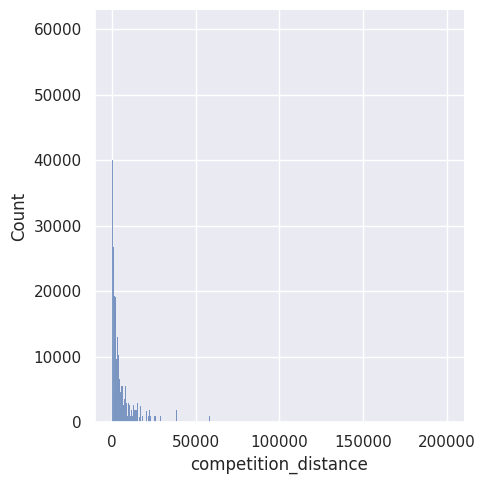

In [18]:
# Plot distribution of competition_distance
sns.displot(df1['competition_distance'], kde=False)

## 5.4 Categorical Attributes

In [19]:
#Unique value counts for categorical attributes
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [20]:
df1.head()

,store,day_ofyear,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [21]:
#exporting df1
df1.to_csv('../data/df1.csv', index=False)